# Lecture 3: Collaborative Filtering and Single Value Decomposition 

## Part 1: Building an Item-Item Recommender

If you use Netflix, you will notice that there is a section titled "Because you watched Movie X", which provides recommendations for movies based on a recent movie that you've watched. This is a classic example of an item-item recommendation. 

## Step 1: Import the Packages

In [156]:
# Import packages 
import numpy as np
import pandas as pd
import sklearn
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import time

from PIL import Image
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Step 2: Load the Data

We're working with the [MovieLens](https://www.wikiwand.com/en/MovieLens) dataset. You can access it via the zip file url [here](https://grouplens.org/datasets/movielens/), or directly download [here](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip). We're working with data in `ml-latest-small.zip` and will need to add the following files to our local directory: 
- ratings.csv
- movies.csv

Alternatively, you can access the data here: 
- https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv
- https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv

In [157]:
# importing data
path = r"C:\Users\Sydney\Downloads\ml-latest-small\ratings.csv"
ratings = pd.read_csv(path)
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [158]:
# importing data
path1 = r"C:\Users\Sydney\Downloads\ml-latest-small\movies.csv"
movies = pd.read_csv(path1)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Step 3: Light EDA

In Part 1 of this tutorial series, we will focus on the `ratings` dataset. We'll need `movies` for subsequent sections. `Ratings` contains users' ratings for a given movie. Let's see how many ratings, unique movies, and unique users are in our dataset. 

In [159]:
n_ratings = len(ratings) # how many ratings do we have?
n_movies = ratings['movieId'].nunique() # how many movies do we have?
n_users = ratings['userId'].nunique() # how many unique users have provided rankings? 

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


Now, let's take a look at users' rating counts. We can do this using pandas' `groupby()` and `count()` which groups the data by `userId`'s and counts the number of ratings for each userId. 

In [160]:
user_freq = ratings[['userId', 'movieId']].groupby('userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
user_freq.head()

,userId,n_ratings
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


In [161]:
print(f"Mean number of ratings for a given user: {user_freq['n_ratings'].mean():.2f}.")

Mean number of ratings for a given user: 165.30.


On average, a user will have rated ~165 movies. Looks like we have some avid movie watchers in our dataset.

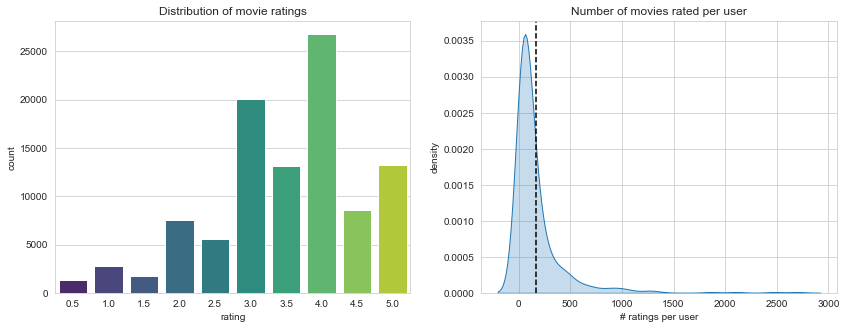

In [162]:
# graphing descriptive statistics -- distribution of movie ratings and density plot of number of ratings given by each user
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings")

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], shade=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per user")
plt.ylabel("density")
plt.title("Number of movies rated per user")
plt.show()

The most common rating is 4.0, while lower ratings such as 0.5 or 1.0 are much more rare. 

### Which movie has the lowest and highest average rating?

In [163]:
mean_rating = ratings.groupby('movieId')[['rating']].mean()

lowest_rated = mean_rating['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


Gypsy (1962) is the worst rated movie!

In [164]:
highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


Lamerica may be the "highest" rated movie. But how many ratings does it have?

In [165]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


Two 5.0 ratings... hm. 

## Step 4: Transforming the data

We will be using a technique called [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) to generate user recommendations. 

The first step of collaborative filtering is to transform our data into a `user-item matrix` - also known as a "utility" matrix. In this matrix, rows represent users and columns represent items. The beauty of collaborative filtering is that it doesn't require any information about the users or items to generate recommendations. 

The `create_X()` function outputs a sparse matrix X with four mapper dictionaries:
- **user_mapper:** maps user id to user index
- **movie_mapper:** maps movie id to movie index
- **user_inv_mapper:** maps user index to user id
- **movie_inv_mapper:** maps movie index to movie id

We need these dictionaries because they map which row and column of the utility matrix corresponds to which user ID and movie ID, respectively.

The **X** (user-item) matrix is a [scipy.sparse.csr_matrix](scipylinkhere) which stores the data sparsely.

In [166]:
# importing scipy package that stores data in sparse matrix
from scipy.sparse import csr_matrix

def create_X(df): #generates sparse matrix from ratings dataframe (argument is pandas df)
    
    N = df['userId'].nunique() # N is list of unique users
    M = df['movieId'].nunique() # M is list of unique movies

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N)))) # dict that maps user ids to user indices 
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M)))) # dict that maps movie ids to movie indices
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"]))) # dict that maps user indices to user id's 
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"]))) # dict that maps movie indices to movie id's
    
    user_index = [user_mapper[i] for i in df['userId']] # list of newly assigned user indices  
    movie_index = [movie_mapper[i] for i in df['movieId']] # list of newly assigned movie indices

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N)) # using rating df to create sparse matrix 
    # with list of new movie indices and user indices, shaped by # of unique users and movies 
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper
    # Returns:
    # X: sparse matrix
    # user_mapper: dict that maps user id's to user indices
    # user_inv_mapper: dict that maps user indices to user id's
    # movie_mapper: dict that maps movie id's to movie indices
    # movie_inv_mapper: dict that maps movie indices to movie id's

In [167]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings) # applying function above to ratings df

Let's check out the sparsity of our X matrix.

Here, we calculate sparsity by dividing the number of non-zero elements by total number of elements as described in the equation below: 

$$S=\frac{\text{# non-zero elements}}{\text{total elements}}$$

In [143]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1]) # dividing number of non-zero items in X matrix
# by total elements, or rows (shape[0]) times columns (shape[1]) to get percentage of non-zero elements in matrix 

print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


Only 1.7% of cells in our user-item matrix are populated with ratings. But don't be discouraged by this sparsity! User-item matrices are typically very sparse. A general rule of thumb is that your matrix sparsity should be no lower than 0.5% to generate decent results.

<img src="images/knn.png" width="20%" align="right"/>

## Step 5: Finding similar movies using k-Nearest Neighbours

This approach looks for the $k$ nearest neighbours of a given movie by identifying $k$ points in the dataset that are closest to movie $m$. kNN makes use of distance metrics such as:

1. Cosine similarity
2. Euclidean distance
3. Manhattan distance
4. Pearson correlation 

Although difficult to visualize, we are working in a M-dimensional space where M represents the number of movies in our X matrix. 

In [144]:
# importing sklearn nearest neighbor package
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False): # finds k-nearest neighbours for a given movie id
    
    # arguments:
    # movie_id: id of the movie of interest
    # X: user-item utility matrix
    # k: number of similar movies to retrieve
    # metric: distance metric for kNN calculations
    
    neighbour_ids = [] # creating an empty list for neighbour id's
    
    movie_ind = movie_mapper[movie_id] # creating a list of our movie id's
    movie_vec = X[movie_ind] # creating a list of our movie indices 
    
    k+=1 # initialize value of k, k = k + 1
    
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric) # assigning nearest neighbor function 
    # assigning nearest neighbors -- # of data points used for classification -- as k 
    # using 'brute' algorithim, simplest of KNN algorithims
    # metric of distance measurement is 'cosine'
    
    kNN.fit(X) # fitting nearest neighbor algorithim to X, our sparse matrix
    
    if isinstance(movie_vec, (np.ndarray)): # if statement function-- checks if the object (first argument) 
        # is an instance or subclass of classinfo class (second argument)
        
        movie_vec = movie_vec.reshape(1,-1) 
        
    neighbour = kNN.kneighbors(movie_vec, return_distance = show_distance) # unsupervised learner for 
    # implementing neighbor searches
    # finds k-neighbors of a point, returns indices of and distances to each point
    
    for i in range(0,k): # for loop iterating from 0 to k 
        
        n = neighbour.item(i) # returns dict of key-value pairs of neighbor indices and distances 
        
        neighbour_ids.append(movie_inv_mapper[n]) # appending movie ID's 
        
    neighbour_ids.pop(0) # removes and return the first item from the list
    
    return neighbour_ids # returns list of k similar movie ID's

`find_similar_movies()` takes in a movieId and user-item X matrix, and outputs a list of $k$ movies that are similar to the movieId of interest. 

Let's see how it works in action. We will first create another mapper that maps `movieId` to `title` so that our results are interpretable. 

In [145]:
movie_titles = dict(zip(movies['movieId'], movies['title'])) # creating a dict of movie ID's and titles 

movie_id = 1 

similar_ids = find_similar_movies(movie_id, X, k=10) # calling function to recommend 10 movies based off movie with ID #1 
movie_title = movie_titles[movie_id] # getting the name of movie w/ id #1

print(f"Because you watched {movie_title}") # iterating through the list of 10 movies returned by find_similar_movies function
for i in similar_ids:
    print(movie_titles[i])

Because you watched Toy Story (1995)
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)
Back to the Future (1985)


The results above show the 10 most similar movies to Toy Story. Most movies in this list are family movies from the 1990s, which seems pretty reasonable. Note that these recommendations are based solely on user-item ratings. Movie features such as genres are not taken into consideration in this approach.  

You can also play around with the kNN distance metric and see what results you would get if you use "manhattan" or "euclidean" instead of "cosine".

In [146]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1
similar_ids = find_similar_movies(movie_id, X, k=10, metric="euclidean") # changing metric to euclidean

movie_title = movie_titles[movie_id]
print(f"Because you watched {movie_title}:")
for i in similar_ids:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Mission: Impossible (1996)
Independence Day (a.k.a. ID4) (1996)
Bug's Life, A (1998)
Nutty Professor, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Babe (1995)
Groundhog Day (1993)
Mask, The (1994)
Honey, I Shrunk the Kids (1989)


# Singular Value Decomposition of an Image 

Singular Value Decomposition (SVD) of a matrix is a factorization of that matrix into three matrices.

The key here is that a black and white image is just a matrix where the numbers represent the intensity of a given pixel, which can be decomposed just like any other.

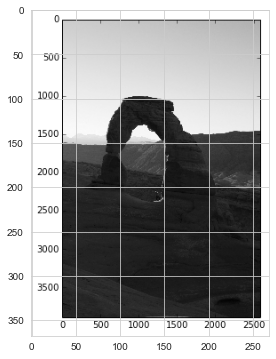

In [147]:
# show the image
img = Image.open(r'C:\Users\Sydney\Downloads\arches_pic.png')
imggray = img.convert('LA')
plt.figure(figsize=(9, 6))
plt.imshow(imggray);

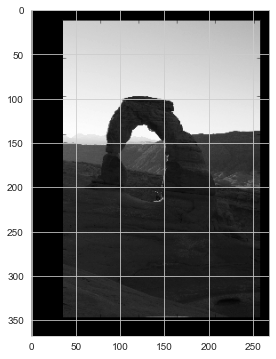

In [148]:
# convert the image to numpy matrix
imgmat = np.array(list(imggray.getdata(band=0)), float)
imgmat.shape = (imggray.size[1], imggray.size[0])
imgmat = np.matrix(imgmat)
plt.figure(figsize=(9,6))
plt.imshow(imgmat, cmap='gray');

Now to compute the singular value decomposition:

In [149]:
# computing singular value decomposition 
U, sigma, V = np.linalg.svd(imgmat)

Computing an approximation of the image using the first column of  U  and first row of  V reproduces the most prominent feature of the image, the light area on top and the dark area on the bottom. 
The darkness of the arch causes the extra darkness in the middle of the reconstruction. Each column of pixels in this image is a different weighting of the same values, as u goes towards 1:

(368, 269)

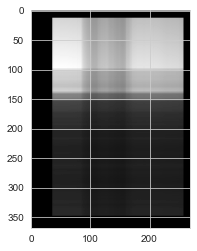

In [153]:
# creating a matrix by multiplying 1st column of U and first row of V
reconstimg = np.matrix(U[:, :1]) * np.diag(sigma[:1]) * np.matrix(V[:1, :])
plt.imshow(reconstimg, cmap='gray');
reconstimg.shape

Even with just the second and third vectors, the shape of the arch begins to appear.

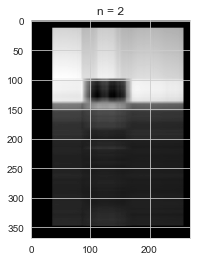

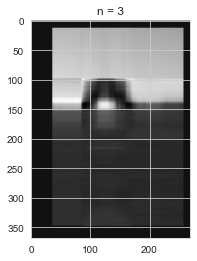

In [154]:
# iterating through 2nd and 3rd vectors 
for i in range(2, 4):
    reconstimg = np.matrix(U[:, :i]) * np.diag(sigma[:i]) * np.matrix(V[:i, :])
    plt.imshow(reconstimg, cmap='gray')
    title = "n = %s" % i
    plt.title(title)
    plt.show()

The loop below shows the reconstructed image using the first  n  vectors of the singular value decomposition ( n  is shown in the title of the plot). The first 50 vectors produce an image very close the original image, while taking up only  (50∗3900+50+50∗26003900∗2600)≈3.2%  as much space as the original data.

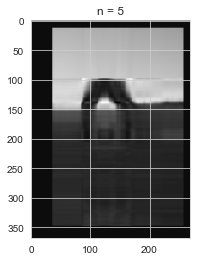

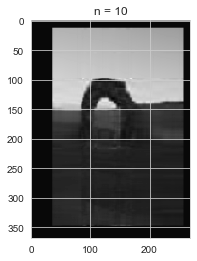

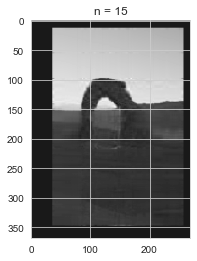

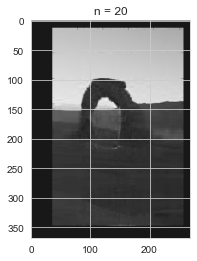

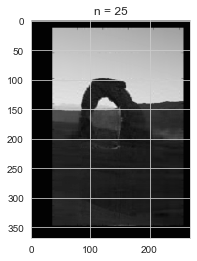

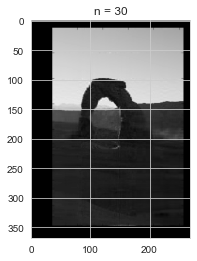

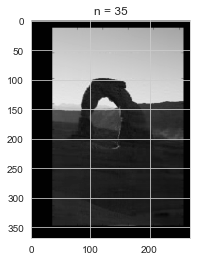

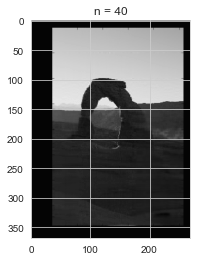

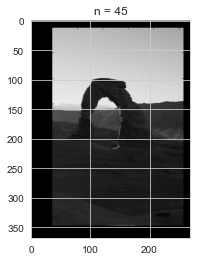

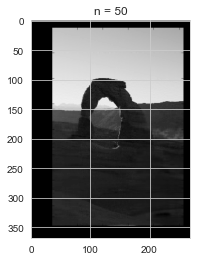

In [155]:
# using the first 50 vectors to produce an image close to original image
for i in range(5, 51, 5):
    reconstimg = np.matrix(U[:, :i]) * np.diag(sigma[:i]) * np.matrix(V[:i, :])
    plt.imshow(reconstimg, cmap='gray')
    title = "n = %s" % i
    plt.title(title)
    plt.show()